## Neural Machine Translation with TensorFlow

In [1]:
import re
import string
from pickle import dump
from numpy import array
from unicodedata import normalize

import tensorflow as tf

#### Load the data

In [2]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
# load dataset
filename = 'deu.txt'

doc = load_doc(filename)

In [4]:
doc[:50]

'Hi.\tHallo!\nHi.\tGrüß Gott!\nRun!\tLauf!\nWow!\tPotzdonn'

#### We must split the loaded text by line and then by phrase. 

Each line contains a single pair of phrases, first English and then German, separated by a tab character.

In [5]:
# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [6]:
pairs = to_pairs(doc)

pairs[:5]

[['Hi.', 'Hallo!'],
 ['Hi.', 'Grüß Gott!'],
 ['Run!', 'Lauf!'],
 ['Wow!', 'Potzdonner!'],
 ['Wow!', 'Donnerwetter!']]

#### Clean each sentence:

- Remove all non-printable characters.
- Remove all punctuation characters.
- Normalize all Unicode characters to ASCII (e.g. Latin characters).
- Normalize the case to lowercase.
- Remove any remaining tokens that are not alphabetic.

In [7]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [8]:
clean_pairs = clean_pairs(pairs)

clean_pairs[:5]

array([['hi', 'hallo'],
       ['hi', 'gru gott'],
       ['run', 'lauf'],
       ['wow', 'potzdonner'],
       ['wow', 'donnerwetter']], dtype='<U370')

In [9]:
for i in range(10):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]


#### Save the list of phrase pairs to a file.

use the pickle API to save the list of clean text to file.

In [10]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [11]:
# save clean pairs to file

save_clean_data(clean_pairs, 'english-german.pkl')

Saved: english-german.pkl


### 2. Split Text
- either load the saved pickle or continue with the cleaned data saved in variable `clean_pairs`
- We will simplify the problem by reducing the dataset to the first 10,000 examples in the file; these will be the shortest phrases in the dataset.

- Further, we will then stake the first 9,000 of those as examples for training and the remaining 1,000 examples to test the fit model.

In [12]:
from pickle import load
from numpy.random import rand
from numpy.random import shuffle

In [13]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [14]:
# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

raw_dataset[:10]

array([['hi', 'hallo'],
       ['hi', 'gru gott'],
       ['run', 'lauf'],
       ['wow', 'potzdonner'],
       ['wow', 'donnerwetter'],
       ['fire', 'feuer'],
       ['help', 'hilfe'],
       ['help', 'zu hulf'],
       ['stop', 'stopp'],
       ['wait', 'warte']], dtype='<U370')

In [15]:
# reduce dataset size
n_sentences = 10000

dataset = raw_dataset[:n_sentences, :]

In [16]:
# random shuffle
shuffle(dataset)

In [17]:
len(dataset)

10000

In [18]:
(20/100) * 152820

30564.0

In [19]:
# split into train/test [80-20]
train, test = dataset[:122256], dataset[122256:]

#### Tokenize Text:
    
We will use separate tokenizer for the English sequences and the German sequences.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#### english

In [22]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])

In [23]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_vocab_size

2404

In [24]:
# find the length of the longest sequence
eng_length = max(len(line.split()) for line in dataset[:, 0])
eng_length

5

In [25]:
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 2404
English Max Length: 5


#### german

In [26]:
ger_tokenizer = create_tokenizer(dataset[:, 1])

In [27]:
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_vocab_size

3856

In [28]:
# find the length of the longest sequence
ger_length = max(len(line.split()) for line in dataset[:, 1])
ger_length

10

In [29]:
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

German Vocabulary Size: 3856
German Max Length: 10


#### Encode sequence to integers and pad to the maximum phrase length.

In [30]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

#### The output sequence needs to be one-hot encoded. This is because the model will predict the probability of each word in the vocabulary as output.

In [31]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = tf.keras.utils.to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [32]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

In [33]:
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

### 3. Build Neural Translation Model

In [34]:
ger_vocab_size = 3856
ger_length = 10

eng_vocab_size = 2404
eng_length = 5

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(ger_vocab_size, 256, input_length=ger_length, mask_zero=True),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.RepeatVector(eng_length),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(eng_vocab_size, activation='softmax'))
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           987136    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 2404)           617828    
Total params: 2,655,588
Trainable params: 2,655,588
Non-trainable params: 0
_________________________________________________________________


#### Compile & Fit model


In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [37]:
filename = 'model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', 
                                                verbose=1, save_best_only=True, mode='min')


history = model.fit(trainX, trainY, epochs=50, batch_size=64, 
                    validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

Epoch 1/50
157/157 [==============================] - 8s 23ms/step - loss: 5.3324
Epoch 2/50
157/157 [==============================] - 3s 19ms/step - loss: 3.5441
Epoch 3/50
157/157 [==============================] - 3s 20ms/step - loss: 3.3740
Epoch 4/50
157/157 [==============================] - 3s 19ms/step - loss: 3.2190
Epoch 5/50
157/157 [==============================] - 3s 21ms/step - loss: 3.0876
Epoch 6/50
157/157 [==============================] - 3s 20ms/step - loss: 2.9445
Epoch 7/50
157/157 [==============================] - 3s 18ms/step - loss: 2.7690
Epoch 8/50
157/157 [==============================] - 3s 18ms/step - loss: 2.5909
Epoch 9/50
157/157 [==============================] - 3s 21ms/step - loss: 2.3939
Epoch 10/50
157/157 [==============================] - 3s 19ms/step - loss: 2.2229
Epoch 11/50
157/157 [==============================] - 3s 19ms/step - loss: 2.0704
Epoch 12/50
157/157 [==============================] - 3s 19ms/step - loss: 1.9451
Epoch 13/50
1

### 4. Evaluate Model

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

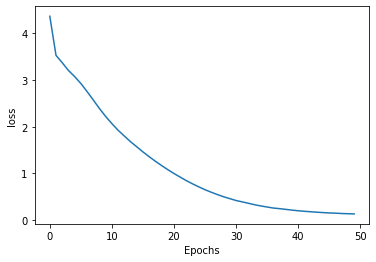

In [39]:
plot_graphs(history, 'loss')

In [40]:
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

In [41]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [42]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [43]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            print('src=[%s] ====> target=[%s] ====> predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    # calculate BLEU score
    print()
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [44]:
print('evaluate train data')
print()
evaluate_model(model, eng_tokenizer, trainX, train)

evaluate train data

src=[sie mussen arbeiten] ====> target=[you must work] ====> predicted=[you must work]
src=[das ist ihr wagen] ====> target=[that is her car] ====> predicted=[that is her car]
src=[tom spendete beifall] ====> target=[tom applauded] ====> predicted=[tom applauded]
src=[ich bin tvsuchtig] ====> target=[im a tv addict] ====> predicted=[im a tv addict]
src=[haltet euch an die regeln] ====> target=[follow the rules] ====> predicted=[follow the rules]
src=[das ist wichtig] ====> target=[it matters] ====> predicted=[its matters]
src=[er wurde freigesprochen] ====> target=[he was acquitted] ====> predicted=[he was acquitted]
src=[ich hatte gern eine limonade] ====> target=[id like a soda] ====> predicted=[id like a soda]
src=[wir sind wohlhabend] ====> target=[were wealthy] ====> predicted=[were wealthy]
src=[tom war traurig] ====> target=[tom felt sad] ====> predicted=[tom felt sad]

BLEU-1: 0.950844
BLEU-2: 0.934439
BLEU-3: 0.878089
BLEU-4: 0.642810
